In [1]:
import pandas as pd
import numpy as np
# Let's employ ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Regression building
from sklearn.linear_model import LinearRegression
from  matplotlib import pyplot 

In [59]:
def file_opener(adress, invert=False, swap=False):
    """ Open and cut our file"""
    df_coll = pd.read_excel(adress,sheet_name=None, header=None)
    list_df=[]
    for it in df_coll.values():
        ''' converting angle if needed'''
        if invert==True and swap==True:
            '''by .iloc[::-1].reset_index(drop=True) we swap the DF upside down 
            and reset old index - to optimize our intercept search'''
            list_df.append(180-pd.DataFrame(it).iloc[1:,1:].iloc[::-1].reset_index(drop=True)) 
        elif invert==True and swap==False:
            list_df.append(180-pd.DataFrame(it).iloc[1:,1:])
        elif invert==False and swap==True:
            list_df.append(pd.DataFrame(it).iloc[1:,1:].iloc[::-1].reset_index(drop=True))
        else:
            list_df.append(pd.DataFrame(it).loc[1:,1:])
    return list_df

def CutData(list_of_df, cut_from=0, cut_to=-1):
    """Cutting off a non-linear part of the curve 
    and extracting mean for each plant"""
    data_cut=[]
    for datafr in list_of_df:
        data_cut.append(datafr.iloc[cut_from:cut_to,:])
    return data_cut

def tukefying(list_of_means):
    '''Converting the data to the edible format for the TukeyHSD'''
    listOM_concat = np.concatenate(list_of_means)
    return pd.DataFrame({'Value': listOM_concat,
                   'Line': np.repeat(['WT', 'PIN7LG', 'PIN7SR', 'Cross', 'pin34', 'pin347'], repeats=len(listOM_concat)/6)})

def reg_extractor(dataframe):
    '''Running linear regression for each column of each dataframe 
    and extracting slopes and intercepts as list of dicts'''
    intercept_slope_list = {'int':[], 'slope':[], 'r_sq':[]}        # dict for data gathering
    x= dataframe.index.to_numpy().reshape((-1, 1))      # reshaping x to 2d array   
    y=dataframe.T.to_numpy()        # converting columns to the separate 1d arrays
    for sub_y in y:
        test_model = LinearRegression(fit_intercept=True).fit(x, sub_y)     # fitting   
        intercept_slope_list['r_sq'].append(test_model.score(x, sub_y))     # extracting r^2
        intercept_slope_list['int'].append(test_model.intercept_)           # extracting intercept
        intercept_slope_list['slope'].append(test_model.coef_[0])           # extracting slope
        # and plot what we've got
        prediction = test_model.predict(x)
        pyplot.scatter(x, sub_y)
        pyplot.plot(np.sort(x, axis=0),prediction)
    pyplot.show()
    return pd.DataFrame(intercept_slope_list)

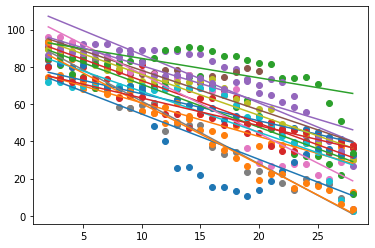

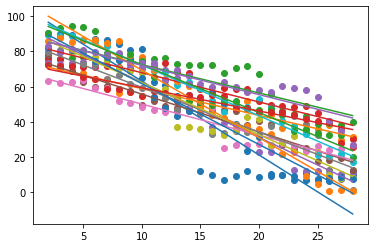

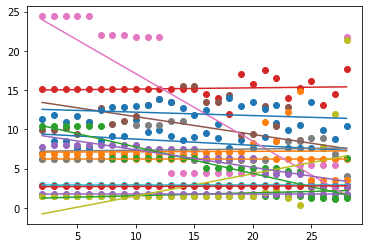

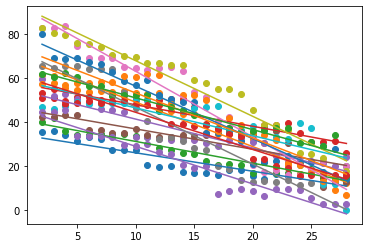

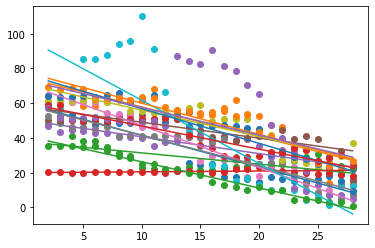

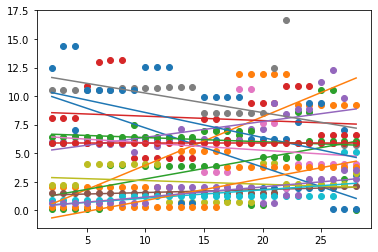

In [60]:
data = file_opener('2019.10.15_GB_sec_rep_data.xlsx', invert=True, swap=True)
linear_per_line=CutData(data, 2, -1) #12,15,10,(8,39 - good) (20,40)
wt=reg_extractor(linear_per_line[0])
P7a=reg_extractor(linear_per_line[1])
P7b=reg_extractor(linear_per_line[2])
cross=reg_extractor(linear_per_line[3])
p34=reg_extractor(linear_per_line[4])
p347=reg_extractor(linear_per_line[5])

In [61]:
r_sq_df=tukefying([wt['r_sq'],P7a['r_sq'], P7b.r_sq, cross.r_sq, p34.r_sq, p347.r_sq])
slope_df=tukefying([wt.slope,P7a.slope, P7b.slope, cross.slope, p34.slope, p347.slope])
intercept_df=tukefying([wt.int,P7a.int, P7b.int, cross.int, p34.int, p347.int])

In [62]:
# perform Tukey's test for r_sq
tukey_r_sq = pairwise_tukeyhsd(endog=r_sq_df['Value'],
                          groups=r_sq_df['Line'],
                          alpha=0.05)

#display results
print(tukey_r_sq)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Cross PIN7LG    0.042    0.9 -0.2223  0.3063  False
 Cross PIN7SR  -0.4138  0.001 -0.6781 -0.1495   True
 Cross     WT  -0.0384    0.9 -0.3027  0.2259  False
 Cross  pin34  -0.1586 0.5025 -0.4229  0.1057  False
 Cross pin347  -0.4788  0.001 -0.7431 -0.2145   True
PIN7LG PIN7SR  -0.4558  0.001 -0.7201 -0.1915   True
PIN7LG     WT  -0.0804    0.9 -0.3447   0.184  False
PIN7LG  pin34  -0.2005 0.2428 -0.4649  0.0638  False
PIN7LG pin347  -0.5208  0.001 -0.7851 -0.2565   True
PIN7SR     WT   0.3754 0.0011  0.1111  0.6398   True
PIN7SR  pin34   0.2552 0.0647 -0.0091  0.5196  False
PIN7SR pin347   -0.065    0.9 -0.3293  0.1993  False
    WT  pin34  -0.1202 0.7431 -0.3845  0.1441  False
    WT pin347  -0.4404  0.001 -0.7048 -0.1761   True
 pin34 pin347  -0.3202 0.0085 -0.5846 -0.0559   True
----------------------------------------------

In [63]:
# perform Tukey's test for slope
tukey_slope = pairwise_tukeyhsd(endog=slope_df['Value'],
                          groups=slope_df['Line'],
                          alpha=0.05)

#display results
print(tukey_slope)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Cross PIN7LG  -0.7752 0.0189 -1.4668 -0.0835   True
 Cross PIN7SR   1.6198  0.001  0.9281  2.3114   True
 Cross     WT  -0.5266 0.2393 -1.2182   0.165  False
 Cross  pin34   0.1461    0.9 -0.5456  0.8377  False
 Cross pin347   1.7284  0.001  1.0368  2.4201   True
PIN7LG PIN7SR   2.3949  0.001  1.7033  3.0866   True
PIN7LG     WT   0.2486    0.9 -0.4431  0.9402  False
PIN7LG  pin34   0.9213 0.0027  0.2296  1.6129   True
PIN7LG pin347   2.5036  0.001   1.812  3.1953   True
PIN7SR     WT  -2.1464  0.001  -2.838 -1.4547   True
PIN7SR  pin34  -1.4737  0.001 -2.1653  -0.782   True
PIN7SR pin347   0.1087    0.9 -0.5829  0.8003  False
    WT  pin34   0.6727 0.0615  -0.019  1.3643  False
    WT pin347   2.2551  0.001  1.5634  2.9467   True
 pin34 pin347   1.5824  0.001  0.8907   2.274   True
----------------------------------------------

In [64]:
# perform Tukey's test for intercept
tukey_intercept = pairwise_tukeyhsd(endog=intercept_df['Value'],
                          groups=intercept_df['Line'],
                          alpha=0.05)

#display results
print(tukey_intercept)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
 Cross PIN7LG  25.5703 0.001   11.8049  39.3358   True
 Cross PIN7SR -54.9893 0.001  -68.7548 -41.2239   True
 Cross     WT  29.5848 0.001   15.8194  43.3503   True
 Cross  pin34  -1.3536   0.9   -15.119  12.4119  False
 Cross pin347 -58.6096 0.001  -72.3751 -44.8442   True
PIN7LG PIN7SR -80.5597 0.001  -94.3251 -66.7942   True
PIN7LG     WT   4.0145   0.9   -9.7509    17.78  False
PIN7LG  pin34 -26.9239 0.001  -40.6893 -13.1584   True
PIN7LG pin347   -84.18 0.001  -97.9454 -70.4145   True
PIN7SR     WT  84.5742 0.001   70.8087  98.3396   True
PIN7SR  pin34  53.6358 0.001   39.8703  67.4012   True
PIN7SR pin347  -3.6203   0.9  -17.3857  10.1451  False
    WT  pin34 -30.9384 0.001  -44.7038 -17.1729   True
    WT pin347 -88.1945 0.001 -101.9599  -74.429   True
 pin34 pin347 -57.2561 0.001  -71.0215 -43.4906   True
----------

In [36]:
pd.concat([pd.DataFrame(['R-square']), pd.DataFrame(tukey_r_sq.summary()), pd.DataFrame(['Slope']),
pd.DataFrame(tukey_slope.summary()), pd.DataFrame(['Intercept']), pd.DataFrame(tukey_intercept.summary())]).to_excel('2019.10.04_PB_slope_regr_tukey_output.xlsx')

C:\Users\kashk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


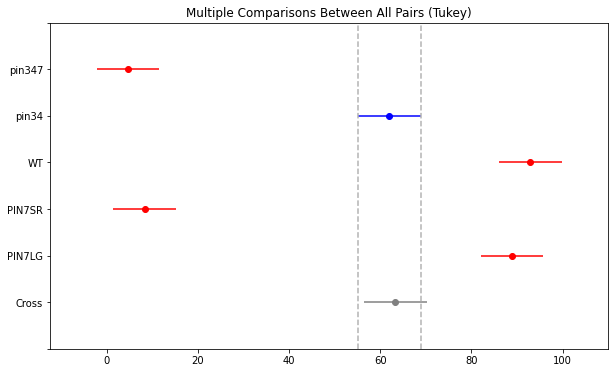

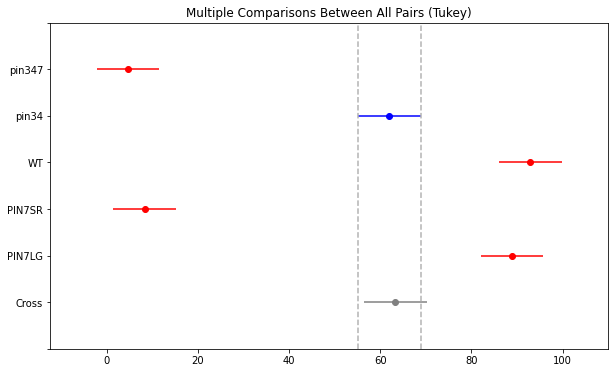

In [65]:
from statsmodels.stats.multicomp import MultiComparison
data=MultiComparison(intercept_df['Value'], intercept_df['Line'])
results=data.tukeyhsd()


results.plot_simultaneous(comparison_name="pin34")